In [1]:
import pymskt as mskt
from itkwidgets import view
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
path_segmentation = '../../data/SAG_3D_DESS_RIGHT_bones_cart_men_fib-label.nrrd'

print('Initiating tibia mesh')
tibia = mskt.mesh.BoneMesh(
    path_seg_image=path_segmentation,
    label_idx=6,
    list_cartilage_labels=[2, 3]
)

print('Creating tibia mesh')
tibia.create_mesh()

print('Calculating cartilage thickness')
tibia.calc_cartilage_thickness()
print('Assigning cartilage regions')
tibia.assign_cartilage_regions()

Initiating tibia mesh
Creating tibia mesh
Calculating cartilage thickness
INTERSECTION IS:  2
INTERSECTION IS:  2
Assigning cartilage regions
INTERSECTION IS:  2
INTERSECTION IS:  2


In [3]:
view(geometries=[tibia])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [6]:
import numpy as np

regions_label = 'labels'
med_tib_cart_label = 2
lat_tib_cart_label = 3

region_array = tibia[regions_label]
med_tib_cart_mask = (region_array == med_tib_cart_label)
lat_tib_cart_mask = (region_array == lat_tib_cart_label)

med_tib_cart_points = tibia.points[med_tib_cart_mask]
lat_tib_cart_points = tibia.points[lat_tib_cart_mask]
tib_cart_points = np.concatenate([med_tib_cart_points, lat_tib_cart_points], axis=0)

# do PCA to get the three axes of the tib_cart_points and take the last
# one as the inf/sup
X = tib_cart_points - tib_cart_points.mean(axis=0, keepdims=True)  # (N,3)
# PCA via SVD: X = U S Vt, rows of Vt are PCs
U, S, Vt = np.linalg.svd(X, full_matrices=False)
pc1, pc2, pc3 = Vt  # already orthonormal

is_axis = pc3

# from the PCA we cant know what it up. We should check which side the meniscus is on...
# or... which side the bone is on... So, from the middle of the cartilage, 
# the opposide of the direction of the middle of the bone is the IS axis. 
mean_tib = np.mean(tibia.points, axis=0)
mean_cart = np.mean(tib_cart_points, axis=0)

# update is_axis direction based on where mean_tib is relative to mean_cart
if np.dot(mean_tib - mean_cart, is_axis) > 0:
    is_axis = -is_axis


med_tib_center = np.mean(med_tib_cart_points, axis=0)
lat_tib_center = np.mean(lat_tib_cart_points, axis=0)

ml_axis = lat_tib_center - med_tib_center
ml_axis = ml_axis / np.linalg.norm(ml_axis)

ap_axis = np.cross(ml_axis, is_axis)
ap_axis = ap_axis / np.linalg.norm(ap_axis)

dict_tibia_axes = {
    'ml_axis': ml_axis,
    'is_axis': is_axis,
    'ap_axis': ap_axis,
    'medial_center': med_tib_center,
    'lateral_center': lat_tib_center,
}

def get_tibia_axes_meniscal_extrusion(
    tibia_mesh, 
    regions_label,
    med_tib_cart_label,
    lat_tib_cart_label,
):
    region_array = tibia_mesh[regions_label]
    med_tib_cart_mask = (region_array == med_tib_cart_label)
    lat_tib_cart_mask = (region_array == lat_tib_cart_label)

    med_tib_cart_points = tibia_mesh.points[med_tib_cart_mask]
    lat_tib_cart_points = tibia_mesh.points[lat_tib_cart_mask]
    tib_cart_points = np.concatenate([med_tib_cart_points, lat_tib_cart_points], axis=0)

    # do PCA to get the three axes of the tib_cart_points and take the last
    # one as the inf/sup
    X = tib_cart_points - tib_cart_points.mean(axis=0, keepdims=True)  # (N,3)
    # PCA via SVD: X = U S Vt, rows of Vt are PCs
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    pc1, pc2, pc3 = Vt  # already orthonormal

    is_axis = pc3
    # from the PCA we cant know what it up. We should check which side the meniscus is on...
    # or... which side the bone is on... So, from the middle of the cartilage, 
    # the opposide of the direction of the middle of the bone is the IS axis. 
    mean_tib = np.mean(tibia.points, axis=0)
    mean_cart = np.mean(tib_cart_points, axis=0)

    # update is_axis direction based on where mean_tib is relative to mean_cart
    if np.dot(mean_tib - mean_cart, is_axis) > 0:
        is_axis = -is_axis
    
    med_tib_center = np.mean(med_tib_cart_points, axis=0)
    lat_tib_center = np.mean(lat_tib_cart_points, axis=0)

    ml_axis = lat_tib_center - med_tib_center
    ml_axis = ml_axis / np.linalg.norm(ml_axis)
    
    ap_axis = np.cross(ml_axis, is_axis)
    ap_axis = ap_axis / np.linalg.norm(ap_axis)

    dict_tibia_axes = {
        'ml_axis': ml_axis,
        'is_axis': is_axis,
        'ap_axis': ap_axis,
        'medial_center': med_tib_center,
        'lateral_center': lat_tib_center,
    }
    
    return dict_tibia_axes


In [8]:
dict_tibia_axes_func = get_tibia_axes_meniscal_extrusion(
    tibia_mesh=tibia, 
    regions_label='labels',
    med_tib_cart_label=2,
    lat_tib_cart_label=3,
)

print(dict_tibia_axes)
print(dict_tibia_axes_func)

{'ml_axis': pyvista_ndarray([-0.9919523 ,  0.12175144,  0.0347462 ], dtype=float32), 'is_axis': array([0.03815307, 0.04018929, 0.9984634 ], dtype=float32), 'ap_axis': array([ 0.12016812,  0.99175525, -0.04451112], dtype=float32), 'medial_center': pyvista_ndarray([-57.089283,  -5.439862,  -9.311588], dtype=float32), 'lateral_center': pyvista_ndarray([-92.64511  ,  -1.0757675,  -8.066135 ], dtype=float32)}
{'ml_axis': pyvista_ndarray([-0.9919523 ,  0.12175144,  0.0347462 ], dtype=float32), 'is_axis': array([0.03815307, 0.04018929, 0.9984634 ], dtype=float32), 'ap_axis': array([ 0.12016812,  0.99175525, -0.04451112], dtype=float32), 'medial_center': pyvista_ndarray([-57.089283,  -5.439862,  -9.311588], dtype=float32), 'lateral_center': pyvista_ndarray([-92.64511  ,  -1.0757675,  -8.066135 ], dtype=float32)}


In [9]:
# now label tibia points as having meniscus above them along the si_axis

med_meniscus = mskt.mesh.Mesh(
    path_seg_image=path_segmentation,
    label_idx=10,
)
med_meniscus.create_mesh()
med_meniscus.consistent_faces()

lat_meniscus = mskt.mesh.Mesh(
    path_seg_image=path_segmentation,
    label_idx=9,
)
lat_meniscus.create_mesh()
lat_meniscus.consistent_faces()


In [10]:
view(geometries=[tibia, med_meniscus, lat_meniscus])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [23]:
tibia.calc_distance_to_other_mesh(
    list_other_meshes=[med_meniscus],
    ray_cast_length=10, 
    name='med_men_dist_mm',
    direction=dict_tibia_axes['is_axis'],
)

tibia.calc_distance_to_other_mesh(
    list_other_meshes=[lat_meniscus],
    ray_cast_length=10, 
    name='lat_men_dist_mm',
    direction=dict_tibia_axes['is_axis'],
)

binary_mask_med_men_above = tibia['med_men_dist_mm'] > 0
binary_mask_lat_men_above = tibia['lat_men_dist_mm'] > 0

binary_mask_med_cart = tibia['labels'] == med_tib_cart_label
binary_mask_lat_cart = tibia['labels'] == lat_tib_cart_label

tibia['med_men_above'] = binary_mask_med_men_above.astype(float)
tibia['lat_men_above'] = binary_mask_lat_men_above.astype(float)
    


In [24]:
view(geometries=[tibia])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [25]:
tibia_med_cart = tibia.copy()
# delete points that are not medial cartilage
tibia_med_cart.remove_points(~binary_mask_med_cart, inplace=True)
tibia_med_cart.clean(inplace=True)

area_med_cart = tibia_med_cart.area

tibia_med_cart_men = tibia_med_cart.copy()
tibia_med_cart_men.remove_points(tibia_med_cart_men['med_men_above'] == 0, inplace=True)
tibia_med_cart_men.clean(inplace=True)

area_med_cart_men = tibia_med_cart_men.area

percent_med_men_coverage = (area_med_cart_men / area_med_cart) * 100

print(f'Med Cart Area: {area_med_cart:.2f} mm^2')
print(f'Med Cart Men Area: {area_med_cart_men:.2f} mm^2')
print(f'Percent Med Men Coverage: {percent_med_men_coverage:.2f}%')

view(geometries=[tibia, tibia_med_cart, tibia_med_cart_men])

Med Cart Area: 868.46 mm^2
Med Cart Men Area: 346.47 mm^2
Percent Med Men Coverage: 39.89%


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [26]:
def get_meniscal_coverage(
    tibia_mesh,
    meniscal_mesh,
    tibia_regions_label,
    tibia_cart_label,
    is_direction,
    meniscus_side,
    ray_cast_length=20,
):
    tibia_mesh.calc_distance_to_other_mesh(
        list_other_meshes=[meniscal_mesh],
        ray_cast_length=ray_cast_length, 
        name=f'{meniscus_side}_men_dist_mm',
        direction=is_direction,
    )
    binary_mask_men_above = tibia_mesh[f'{meniscus_side}_men_dist_mm'] > 0
    binary_mask_cart = tibia_mesh[tibia_regions_label] == tibia_cart_label
    tibia_mesh[f'{meniscus_side}_men_above'] = binary_mask_men_above.astype(float)
    tibia_mesh[f'{meniscus_side}_cart'] = binary_mask_cart.astype(float)

    tibia_cart = tibia_mesh.copy()
    # delete points that are not medial cartilage
    tibia_cart.remove_points(~binary_mask_cart, inplace=True)
    tibia_cart.clean(inplace=True)

    area_cart = tibia_cart.area

    tibia_cart_men = tibia_cart.copy()
    tibia_cart_men.remove_points(tibia_cart_men[f'{meniscus_side}_men_above'] == 0, inplace=True)
    tibia_cart_men.clean(inplace=True)

    area_cart_men = tibia_cart_men.area

    percent_cart_men_coverage = (area_cart_men / area_cart) * 100
    
    dict_meniscal_coverage = {
        f'{meniscus_side}_cart_men_coverage': percent_cart_men_coverage,
        f'{meniscus_side}_cart_men_area': area_cart_men,
        f'{meniscus_side}_cart_area': area_cart,
    }
    
    return dict_meniscal_coverage

dict_med_men_coverage = get_meniscal_coverage(
    tibia_mesh=tibia,
    meniscal_mesh=med_meniscus,
    tibia_regions_label='labels',
    tibia_cart_label=2,
    meniscus_side='med',
    is_direction=dict_tibia_axes['is_axis'],
)

dict_lat_men_coverage = get_meniscal_coverage(
    tibia_mesh=tibia,
    meniscal_mesh=lat_meniscus,
    tibia_regions_label='labels',
    tibia_cart_label=3,
    meniscus_side='lat',
    is_direction=dict_tibia_axes['is_axis'],
)
        

In [27]:
print(dict_med_men_coverage)
print(dict_lat_men_coverage)

{'med_cart_men_coverage': 39.89438019552111, 'med_cart_men_area': 346.4668587995976, 'med_cart_area': 868.460312208322}
{'lat_cart_men_coverage': 59.36730303771416, 'lat_cart_men_area': 438.1155627617297, 'lat_cart_area': 737.9745084317016}


In [28]:
"""
Now I want to work on extrusion. 
- We have the ML axis from the tibia.
- We have the medial/lateral meniscus segmentation on the bone to define the edge that
extrusion will be compared against. 
- We will use the meniscus itself to define the extrusion depth.

- We are just going to bin X number of bins in the AP direction (disregarding what is front/back)
- We will compute extrusion +/- for each bin
- We will then return the: mean, median, min, max, std of extrusion. 
"""

'\nNow I want to work on extrusion. \n- We have the ML axis from the tibia.\n- We have the medial/lateral meniscus segmentation on the bone to define the edge that\nextrusion will be compared against. \n- We will use the meniscus itself to define the extrusion depth.\n\n- We are just going to bin X number of bins in the AP direction (disregarding what is front/back)\n- We will compute extrusion +/- for each bin\n- We will then return the: mean, median, min, max, std of extrusion. \n'

In [29]:
# project all med cart points onto the ML axis
tib_cart_label = 'labels'
med_tib_cart_label = 2
lat_tib_cart_label = 3

med_cart_points = tibia[tib_cart_label] == med_tib_cart_label

med_cart_points = tibia.points[med_cart_points]

# project med_cart_points onto the ML axis
ml_axis = dict_tibia_axes['ml_axis']
med_cart_points_ml = np.dot(med_cart_points, ml_axis)

# get medial meniscus points & project onto the ML axis
med_men_points = med_meniscus.points
med_men_points_ml = np.dot(med_men_points, ml_axis)

# get the min of the medial cart and the min of the medial men
min_med_cart_ml = np.min(med_cart_points_ml)
min_med_men_ml = np.min(med_men_points_ml)

extrusion = min_med_men_ml - min_med_cart_ml

print(f'Extrusion: {extrusion:.2f} mm')


Extrusion: -3.97 mm


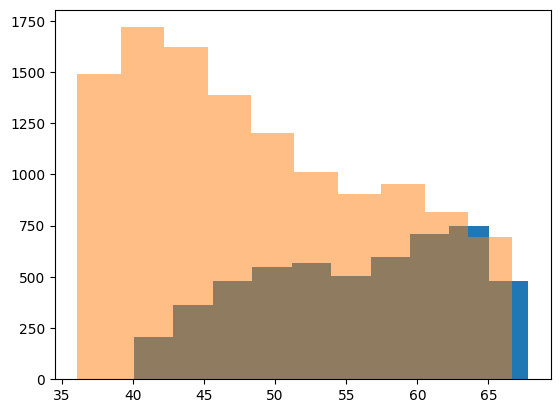

In [30]:
plt.hist(med_cart_points_ml)
plt.hist(med_men_points_ml, alpha=0.5)
plt.show()

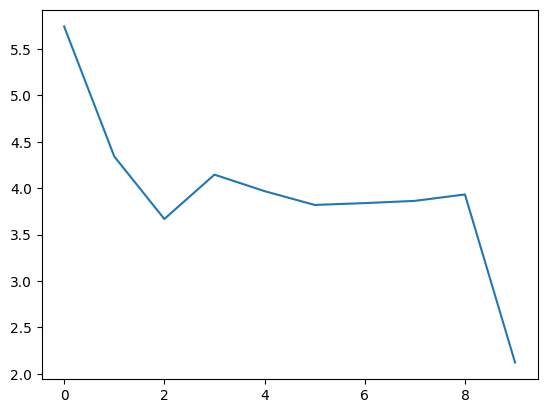

In [31]:
def _get_extrusion_points(
    cart_points,
    men_points,
    ml_axis,
    side,
):
    cart_points_ml = np.dot(cart_points, ml_axis)
    men_points_ml = np.dot(men_points, ml_axis)

    if side in ['med', 'medial']:
        cart_edge = np.min(cart_points_ml)
        men_edge = np.min(men_points_ml)
        extrusion = cart_edge - men_edge
    elif side in ['lat', 'lateral']:
        cart_edge = np.max(cart_points_ml)
        men_edge = np.max(men_points_ml)
        extrusion = men_edge - cart_edge
    else:
        raise ValueError(f'Invalid side: {side}, must be one of: med, medial, lat, lateral')

    return extrusion


# breakup points by bins in the AP direction. 
n_bins = 10

tib_cart_label = 'labels'
med_tib_cart_label = 2
lat_tib_cart_label = 3

med_cart_points = tibia[tib_cart_label] == med_tib_cart_label
med_cart_points = tibia.points[med_cart_points]

med_men_points = med_meniscus.points

ap_axis = dict_tibia_axes['ap_axis']

# project med_cart_points onto the AP axis
med_cart_points_ap = np.dot(med_cart_points, ap_axis)
min_med_cart_ap = np.min(med_cart_points_ap)
max_med_cart_ap = np.max(med_cart_points_ap)
bins = np.linspace(min_med_cart_ap, max_med_cart_ap, n_bins+1)

med_men_points_ap = np.dot(med_men_points, ap_axis)

list_extrusions = []
for i in range(n_bins):
    bin_start = bins[i]
    bin_end = bins[i+1]
    bin_mask_cart = (med_cart_points_ap >= bin_start) & (med_cart_points_ap < bin_end)
    bin_cart_points = med_cart_points[bin_mask_cart]
    bin_mask_men = (med_men_points_ap >= bin_start) & (med_men_points_ap < bin_end)
    bin_men_points = med_men_points[bin_mask_men]
    
    extrusion = _get_extrusion_points(
        cart_points=bin_cart_points,
        men_points=bin_men_points,
        ml_axis=ml_axis,
        side='med',
    )
    list_extrusions.append(extrusion)
    
plt.plot(list_extrusions)


In [32]:
def get_extrusion_stats_percentile(
    tibia_mesh,
    regions_label,
    cart_label,
    meniscus_mesh,
    ap_axis,
    ml_axis,
    side,
    middle_percentile_range=0.1,
):
    cart_indices = tibia_mesh[regions_label] == cart_label
    cart_points = tibia_mesh.points[cart_indices]
    men_points = meniscus_mesh.points

    # project med_cart_points onto the AP axis
    cart_points_ap = np.dot(cart_points, ap_axis)
    min_cart_ap = np.min(cart_points_ap)
    max_cart_ap = np.max(cart_points_ap)
    
    # get the middle +/- middle_percentile_range/2 of the med_cart_points_ap
    # along the AP axis
    middle_ap_cartilage = (min_cart_ap + max_cart_ap) / 2
    min_max_ap_cartilage_range = max_cart_ap - min_cart_ap
    plus_minus_ap_cartilage_range = min_max_ap_cartilage_range * middle_percentile_range / 2    
    lower_ap_cartilage = middle_ap_cartilage - plus_minus_ap_cartilage_range
    upper_ap_cartilage = middle_ap_cartilage + plus_minus_ap_cartilage_range
    
    # get the points along the AP axis that are within the lower_ap_cartilage and upper_ap_cartilage
    ap_cart_indices = (cart_points_ap >= lower_ap_cartilage) & (cart_points_ap <= upper_ap_cartilage)
    # ap_cart_points = med_cart_points[ap_cart_indices]
    
    # project meniscus points onto the AP axis
    men_points_ap = np.dot(men_points, ap_axis)
    
    # get the points along the AP axis that are within the lower_ap_cartilage and upper_ap_cartilage
    ap_men_indices = (men_points_ap >= lower_ap_cartilage) & (men_points_ap <= upper_ap_cartilage)
    # ap_men_points = men_points[ap_men_indices]
    
    # we now have the ap_men_indices and ap_cart_indices
    # we now need to extract the ml projected coordinates for these
    # ap points
    ml_cart_points = cart_points[ap_cart_indices]
    ml_men_points = men_points[ap_men_indices]
    
    # get the extrusion for each point
    extrusion = _get_extrusion_points(
        cart_points=ml_cart_points,
        men_points=ml_men_points,
        ml_axis=ml_axis,
        side=side,
    )
    
    return extrusion


med_men_extrusion = get_extrusion_stats_percentile(
    tibia_mesh=tibia,
    regions_label='labels',
    cart_label=2,
    meniscus_mesh=med_meniscus,
    ap_axis=dict_tibia_axes['ap_axis'],
    ml_axis=dict_tibia_axes['ml_axis'],
    middle_percentile_range=0.1,
    side='med',
)

lat_men_extrusion = get_extrusion_stats_percentile(
    tibia_mesh=tibia,
    regions_label='labels',
    cart_label=3,
    meniscus_mesh=lat_meniscus,
    ap_axis=dict_tibia_axes['ap_axis'],
    ml_axis=dict_tibia_axes['ml_axis'],
    middle_percentile_range=0.1,
    side='lat',
)

    
    
    
print(f'Med Men Extrusion: {med_men_extrusion:.2f} mm')
print(f'Lat Men Extrusion: {lat_men_extrusion:.2f} mm')

late_men_shifted = lat_meniscus.copy()
late_men_shifted.points -= [5, 0, 0]

lat_men_shift_extrusion = get_extrusion_stats_percentile(
    tibia_mesh=tibia,
    regions_label='labels',
    cart_label=3,
    meniscus_mesh=late_men_shifted,
    ap_axis=dict_tibia_axes['ap_axis'],
    ml_axis=dict_tibia_axes['ml_axis'],
    middle_percentile_range=0.1,
    side='lat',
)

print(f'Lat Men Shift Extrusion: {lat_men_shift_extrusion:.2f} mm')

med_men_shifted = med_meniscus.copy()
med_men_shifted.points -= [5, 0, 0]

med_men_shift_extrusion = get_extrusion_stats_percentile(
    tibia_mesh=tibia,
    regions_label='labels',
    cart_label=2,
    meniscus_mesh=med_men_shifted,
    ap_axis=dict_tibia_axes['ap_axis'],
    ml_axis=dict_tibia_axes['ml_axis'],
    middle_percentile_range=0.1,
    side='med',
)

print(f'Med Men Shift Extrusion: {med_men_shift_extrusion:.2f} mm')


Med Men Extrusion: 3.89 mm
Lat Men Extrusion: -0.47 mm
Lat Men Shift Extrusion: 4.33 mm
Med Men Shift Extrusion: -1.22 mm


In [33]:
view(geometries=[tibia, late_men_shifted, med_men_shifted])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [37]:
def get_med_lat_extrusion(
    tibia_mesh,
    regions_label,
    med_cart_label,
    lat_cart_label,
    med_meniscus_mesh,
    lat_meniscus_mesh,
    ap_axis,
    ml_axis,
    middle_percentile_range=0.1,
):
    med_men_extrusion = get_extrusion_stats_percentile(
        tibia_mesh=tibia,
        regions_label='labels',
        cart_label=med_cart_label,
        meniscus_mesh=med_meniscus_mesh,
        ap_axis=ap_axis,
        ml_axis=ml_axis,
        middle_percentile_range=middle_percentile_range,
        side='med',
    )
    
    lat_men_extrusion = get_extrusion_stats_percentile(
        tibia_mesh=tibia,
        regions_label='labels',
        cart_label=lat_cart_label,
        meniscus_mesh=lat_meniscus_mesh,
        ap_axis=ap_axis,
        ml_axis=ml_axis,
        middle_percentile_range=middle_percentile_range,
        side='lat',
    )
    
    dict_extrusions = {
        f'med_men_extrusion_middle_{middle_percentile_range}p_mm': med_men_extrusion,
        f'lat_men_extrusion_middle_{middle_percentile_range}p_mm': lat_men_extrusion,
    }
    return dict_extrusions
    

dict_extrusions = get_med_lat_extrusion(
    tibia_mesh=tibia,
    regions_label='labels',
    med_cart_label=2,
    lat_cart_label=3,
    med_meniscus_mesh=med_meniscus,
    lat_meniscus_mesh=lat_meniscus,
    ap_axis=dict_tibia_axes['ap_axis'],
    ml_axis=dict_tibia_axes['ml_axis'],
    middle_percentile_range=0.1,
)


print(dict_extrusions)

{'med_men_extrusion_middle_0.1p_mm': np.float32(3.8892097), 'lat_men_extrusion_middle_0.1p_mm': np.float32(-0.4709015)}
